In [1]:
import os
from tramdag import TramDagModel, TramDagConfig

In [2]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='counterf') # works also without arguments, then default paths are used

Configuration already exists: counterf/configuration.json


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


n = 1000

x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.choice([0,1], size=n)
x3 = np.random.choice([0,1,2], size=n)
x4 = np.random.exponential(scale=1.0, size=n)
x5 = np.random.choice([0,1,2,3], size=n)
x6 = np.random.exponential(scale=1.0, size=n)
x7 = np.random.choice([0,1,2,3,4], size=n)


df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "x3": x3,
    "x4": x4,
    "x5": x5,
    "x6": x6,
    "x7": x7,
})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  x2  x3        x4  x5        x6  x7
0  0.315628   1   0  4.262243   3  1.014089   4
1  0.952351   1   0  1.256501   1  0.056275   3
2  1.048334   1   2  0.077984   2  0.721956   4
3  0.670491   1   1  0.447175   3  3.192182   4
4 -0.578025   1   2  1.270981   3  0.088902   4


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'ordinal_Xn_Yo', 
            'x3':'ordinal_Xn_Yo',
            'x4':'continous',
            'x5':'ordinal_Xn_Yo',
            'x6':'continous',
            'x7':'ordinal_Xn_Yo',} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x4                   | continous       | continuous [c]                 | continuous [c]                
x5                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x6                   | continous       | continuous [c]  

/home/bule/TramDag/tramdag/utils/configuration.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


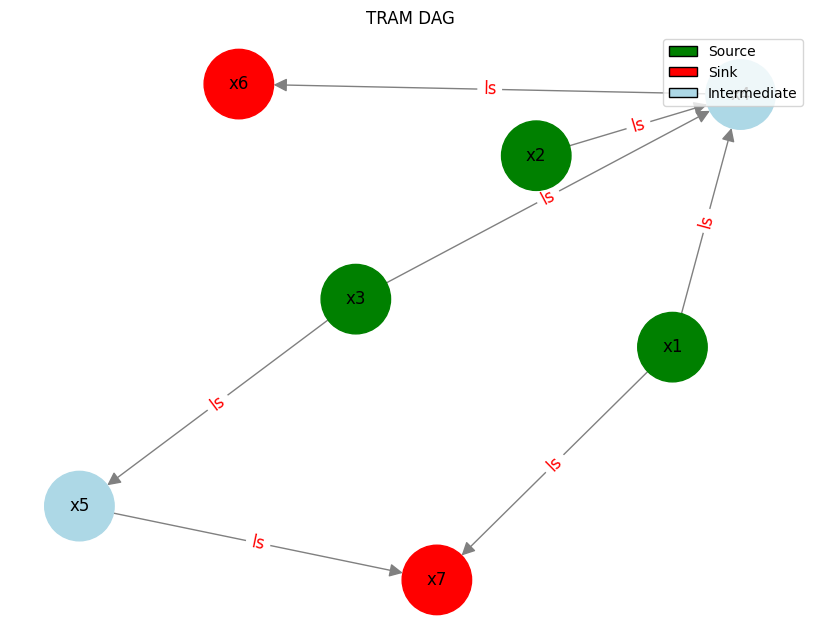

In [5]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

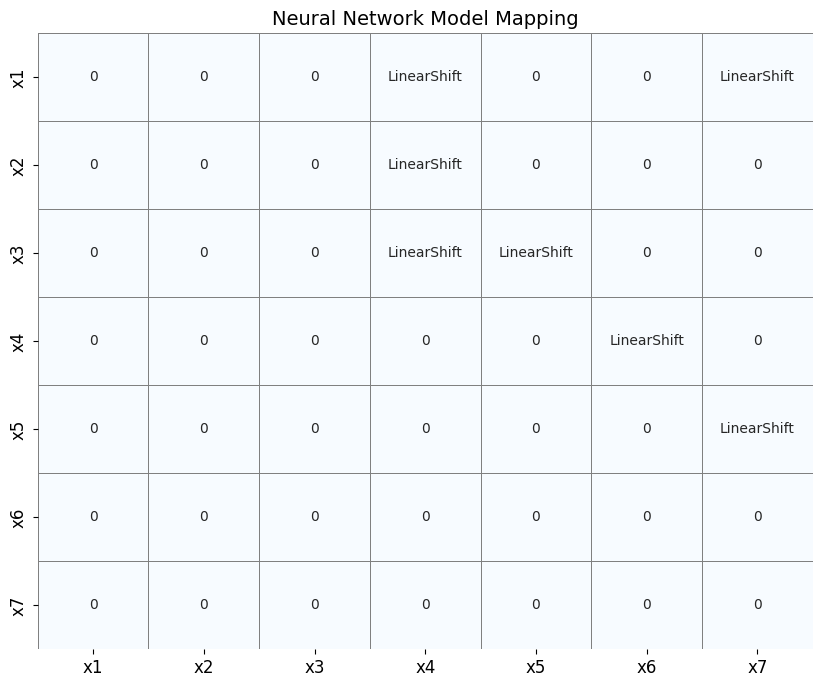

In [6]:
cfg.set_tramdag_nn_models() 


In [7]:
cfg.compute_levels(train_df)

In [8]:
from tramdag import TramDagModel
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )

In [9]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to counterf/min_max_scaling.json


In [10]:
sub = test_df.sample(n=3, random_state=42)
sub

,x1,x2,x3,x4,x5,x6,x7
365,1.043106,0,1,2.020359,2,0.110282,3
583,-1.231927,0,0,0.098567,3,0.236749,1
879,0.008173,1,2,1.445041,0,0.895093,1


In [11]:
u_df = td_model.get_latent(sub)

[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, using initial_model.pt
[Warning] best_model.pt not found, using initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[WARNING] Ordinal 'x5' has 3 unique values, expected 4. Skipping strict comparison.
[Warning] best_model.pt not found, using initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[WARNING] Ordinal 'x5' has 3 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.int64(0), np.int64(2), np.int64(3)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x7' has 2 unique values, expected 5. Skipping strict comparison.
[WARNING] Ordinal 'x5' has 3 unique values, expected 4. Skipping strict comparison.
[Warning] best_model.pt not found, using initial_model.pt
[INFO] Final latent DataFrame shape: (3, 18)


In [12]:
u_df

,x1,x1_U,x2,x2_U_lower,x2_U_upper,x3,x3_U_lower,x3_U_upper,x4,x4_U,x5,x5_U_lower,x5_U_upper,x6,x6_U,x7,x7_U_lower,x7_U_upper
365,1.043106,0.273354,0,-inf,-0.340984,1,0.801221,2.847972,2.020359,0.023790,2,2.735454,4.215600,0.110282,-0.771716,3,2.756064,4.424618
583,-1.231927,-0.305963,0,-inf,-0.340984,0,-inf,0.801221,0.098567,0.933983,3,3.632949,inf,0.236749,-0.367384,1,-1.543179,-0.644424
879,0.008173,-0.005813,1,-0.340984,inf,2,2.847972,inf,1.445041,-0.306768,0,-inf,1.200097,0.895093,-0.446580,1,-0.927743,-0.028988


In [13]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_df,number_of_counterfactual_samples=100)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 3
[INFO] Deleting all previously sampled data.
Deleted directory: counterf/x1/sampling
Deleted directory: counterf/x2/sampling
Deleted directory: counterf/x3/sampling
Deleted directory: counterf/x4/sampling
Directory does not exist: counterf/x5/sampling
Directory does not exist: counterf/x6/sampling
Directory does not exist: counterf/x7/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x1'. Using initial weights instead.
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1132.16it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[INFO] Detected 'x2_U_lower' and 'x2_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x2: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x3'. Using initial weights instead.
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x3: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x4'. Using initial weights instead.
[INFO] Using predefined latents samples for node x4 from dataframe column: x4_U


Sampling x4:   0%|          | 0/3 [00:00<?, ?it/s]

         x1   x2   x3
0  1.043103  0.0  1.0
1  1.043103  0.0  1.0
2  1.043103  0.0  1.0
3  1.043103  0.0  1.0
4  1.043103  0.0  1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float32
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
dtypes: float32(1), float64(2)
memory usage: 19.7 KB
None
torch.Size([3])
[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(0.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(1.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' h

Sampling x4:   0%|          | 0/3 [00:00<?, ?it/s]


ValueError: Mismatch in sample count: thetas_expanded has shape torch.Size([1000, 20]), expected 3 rows.